# Trying Out Jax
Note: all cells outside the initial setup section are written so they can be executed in isolation.

## Initial Setup

In [44]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, value_and_grad, grad, vmap
from jax._src.api import block_until_ready
import matplotlib.pyplot as plt

# Only using these for data loading.
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [6]:
def custom_transform(x):
    x = np.ravel(np.array(x, dtype=np.float32))
    return x

def custom_collate(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    labels = np.eye(10)[labels]
    images = np.stack(transposed_data[0])
    return images, labels

def load_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        custom_transform,
    ])

    train_dataset = MNIST(root='data/', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='data/', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size, 
        shuffle=True, 
        collate_fn=custom_collate
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size, 
        shuffle=True, 
        collate_fn=custom_collate
    )

    return train_loader, test_loader

## Updating Arrays Functionally

In [ ]:
# Arrays are immutable in Jax, so x[0] = y won't work.
# Keys are also passed to random.normal() explicitly instead of relying on explicit state.
key = jax.random.PRNGKey(100)
x = jax.random.normal(key=key, shape=(5,))
print('Original x:', x)
x = x.at[0].set(20.0)
print('Updated x:', x)

Original x: [-0.69846076 -0.7054794   1.3151264  -2.0337505  -0.08158301]
Updated x: [20.         -0.7054794   1.3151264  -2.0337505  -0.08158301]


## Speed Test

In [ ]:
key = jax.random.PRNGKey(100)
x = jax.random.normal(key, shape=(1000, 1000))
key = jax.random.PRNGKey(200)
y = jax.random.normal(key, shape=(1000, 1000))

def numpy_matmul(x, y):
    return np.dot(x, y)

def jnp_matmul(x, y):
    return jnp.dot(x, y)

# Just-in-time (JIT) compilation can be used to speed up execution.
jnp_matmul_compiled = jit(jnp_matmul)

print("np matmul:")
%timeit numpy_matmul(x, y)
print("jnp matmul:")
%timeit jnp_matmul(x, y).block_until_ready()
print("jnp matmul compiled:")
%timeit jnp_matmul_compiled(x, y).block_until_ready()

np matmul:
28.3 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
jnp matmul:
1 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
jnp matmul compiled:
576 µs ± 3.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## FEBAM/Hebbian Learning
https://ieeexplore.ieee.org/document/4371210d

https://github.com/hayden-donnelly/febam

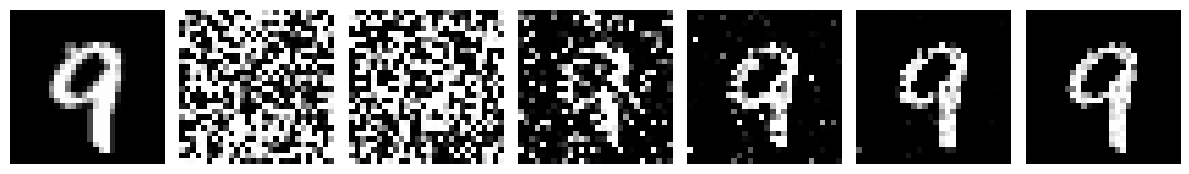

In [ ]:
def create_febam(key, x_dim, y_dim):
    W_key, V_key = jax.random.split(key, 2)
    W = jax.random.normal(W_key, shape=(y_dim, x_dim))
    V = jax.random.normal(V_key, shape=(x_dim, y_dim))
    return (W, V)

def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

def execute_febam(weights, x0):
    W = weights[0]
    V = weights[1]
    y0 = sigmoid(jnp.dot(W, x0))
    x1 = sigmoid(jnp.dot(V, y0))
    y1 = sigmoid(jnp.dot(W, x1))
    return x1, y1, y0

def update_weights(weights, x0, xt, y0, yt, lr):
    W = weights[0]
    V = weights[1]
    W_diff = lr * jnp.outer(y0 - yt, x0 + xt,)
    V_diff = lr * jnp.outer(x0 - xt, y0 + yt,)
    return (W + W_diff, V + V_diff)

# Set hyperparameters
epochs = 50
lr = 0.005
batch_size = 1
x_dim = 784
y_dim = 200

# Load data.
key = jax.random.PRNGKey(1)
train_loader, _ = load_mnist(batch_size)
image = next(iter(train_loader))[0].squeeze()

# Create model.
febam_weights = create_febam(key, x_dim, y_dim)

# Compile inference and learning functions.
execute_febam_c = jit(execute_febam)
update_weights_c = jit(update_weights)

# Train the model.
x_throughout_training = [image.reshape(28, 28)]
x0 = image
xt, yt, y0 = execute_febam_c(febam_weights, x0)
febam_weights = update_weights_c(febam_weights, x0, xt, yt, y0, lr)
x_throughout_training.append(xt.reshape(28, 28))

for epoch in range(epochs-1):
    xt, yt, _ = execute_febam_c(febam_weights, xt)
    febam_weights = update_weights_c(febam_weights, x0, xt, yt, y0, lr)

    if epoch % 10 == 0:
        x_throughout_training.append(xt.reshape(28, 28))

fig, axs = plt.subplots(1, len(x_throughout_training),  figsize=(12, 12))
for i, img in enumerate(x_throughout_training):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## MLP/Backpropagation

Layer 0, weights shape: (800, 784), bias shape: (800,)
Layer 1, weights shape: (10, 800), bias shape: (10,)
Epoch: 1 Loss: 0.1801504
Epoch: 2 Loss: 0.18004031
Epoch: 3 Loss: 0.17992896
Epoch: 4 Loss: 0.1798279
Epoch: 5 Loss: 0.1797907
Epoch: 6 Loss: 0.17972516
Epoch: 7 Loss: 0.1796904
Epoch: 8 Loss: 0.1795577
Epoch: 9 Loss: 0.179457
Epoch: 10 Loss: 0.17937404


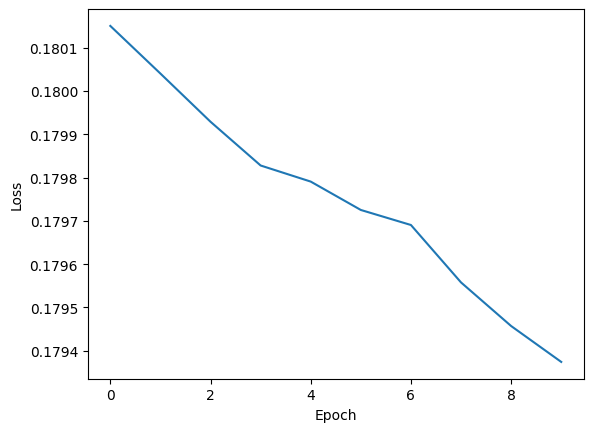

In [98]:
def relu(x):
    return jnp.maximum(0, x)

def softmax(x):
    # subtract the max of x for numerical stability
    x = x - jnp.max(x)
    # compute the exponential of x
    exp_x = jnp.exp(x)
    # normalize by the sum of exp_x
    return exp_x / jnp.sum(exp_x)

def mlp_forward(mlp, x):
    for i in range(len(mlp) - 1):
        weights, biases = mlp[i]
        x = jnp.dot(weights, x)
        x = jnp.add(biases, x)
        x = relu(x)
    weights, biases = mlp[-1]
    x = jnp.dot(weights, x)
    x = jnp.add(biases, x)
    x = softmax(x)
    return x

# Vectorize forward pass so it can handle multiple images per batch.
batched_mlp_forward = vmap(mlp_forward, in_axes=(None, 0))

def mse(mlp, images, labels):
    predictions = batched_mlp_forward(mlp, images)
    return jnp.mean(jnp.square(labels - predictions))

def update_mlp(mlp, images, labels, lr):
    loss, grads = value_and_grad(mse)(mlp, images, labels)
    return loss, jax.tree_map(lambda p, g: p - lr * g, mlp, grads)

def create_mlp(parent_key, layer_widths):
    mlp = []
    layer_keys = jax.random.split(parent_key, len(layer_widths))
    
    for i in range(1, len(layer_widths)):
        weight_and_bias_keys = jax.random.split(layer_keys[i], 2)
        layer_weights = jax.random.normal(weight_and_bias_keys[0], shape=(layer_widths[i], layer_widths[i-1]))
        layer_biases = jax.random.normal(weight_and_bias_keys[1], shape=(layer_widths[i],))
        mlp.append((layer_weights, layer_biases))

    return mlp

def summarize_mlp(mlp):
    for i, layer in enumerate(mlp):
        weight_summary = ', weights shape: ' + str(layer[0].shape)
        bias_summary = ', bias shape: ' + str(layer[1].shape)
        print('Layer ' + str(i) + weight_summary + bias_summary)

# Set hyperparameters.
key = jax.random.PRNGKey(20)
mlp = create_mlp(key, [784, 800, 10])
epochs = 10
batch_size = 32
learning_rate = 0.0001

# Show summary of model.
summarize_mlp(mlp)

# Load data.
train_loader, test_loader = load_mnist(batch_size)

# Train.
losses = []
for epoch in range(epochs):
    cumulative_loss = []
    for images, labels in train_loader:
        loss, mlp = update_mlp(mlp, images, labels, 0.001)
        cumulative_loss.append(loss)
    losses.append(sum(cumulative_loss) / len(cumulative_loss))
    print('Epoch:', epoch + 1, 'Loss:', losses[-1])


fig, ax = plt.subplots()
ax.plot([epoch for epoch in range(epochs)], losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()